In [47]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt

from chess_funcs import ChessDataset
from ml_funcs import ChessEvaluationCNN

In [2]:
csv_file = 'random_evals.csv'
chess_dataset = ChessDataset(csv_file)

small_subset = torch.utils.data.Subset(chess_dataset, np.random.choice(list(range(len(chess_dataset))), size=100000))

test_subset = torch.utils.data.Subset(chess_dataset, np.random.choice(list(range(len(chess_dataset))), size=10000))
test_data_loader = DataLoader(test_subset, batch_size=10000)
data_loader = DataLoader(small_subset, batch_size=128, shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChessEvaluationCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    test_loss = 0.0

    for i, batch in enumerate(data_loader):
        board_tensor = batch['board_tensor'].to(device)
        active_player = batch['active_player'].to(device)
        halfmove_clock = batch['halfmove_clock'].to(device)
        target = batch['evaluation'].to(device)  # Stockfish evaluation

        #optimizer.zero_grad()

        output = model(board_tensor, active_player, halfmove_clock)
        output = output.squeeze(1)
        loss = criterion(output, target)
        #loss.backward()
        #optimizer.step()

        train_running_loss += loss.item()
    train_epoch_loss = train_running_loss / len(data_loader)
    train_loss_history.append(train_epoch_loss)

    test_batch = next(iter(test_data_loader))
    board_tensor = test_batch['board_tensor'].to(device)
    active_player = test_batch['active_player'].to(device)
    halfmove_clock = test_batch['halfmove_clock'].to(device)
    target = test_batch['evaluation'].to(device)  # Stockfish evaluation

    output = model(board_tensor, active_player, halfmove_clock)
    output = output.squeeze(1)
    loss = criterion(output, target)

    test_loss += loss.item() / len(test_data_loader)
    test_loss_history.append(test_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_epoch_loss:.4f}, Test Loss: {test_loss:.4f} ",
          end='\r')

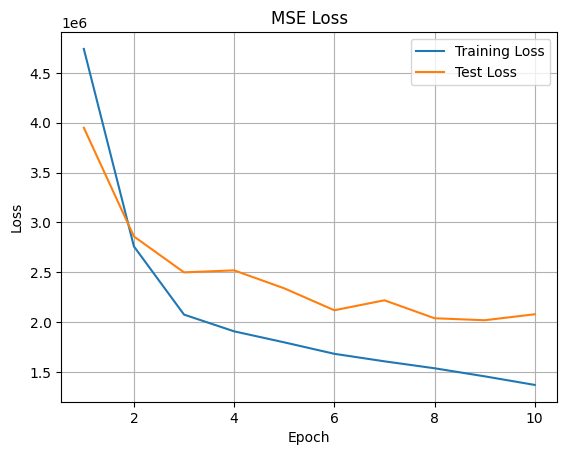

In [46]:
df_train = pd.DataFrame({'Epoch': range(1, num_epochs + 1), 'Loss': train_loss_history})
df_test = pd.DataFrame({'Epoch': range(1, num_epochs + 1), 'Loss': test_loss_history})

plt.plot(df_train['Epoch'], df_train['Loss'], label="Training Loss")
plt.plot(df_test['Epoch'], df_test['Loss'], label="Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss')
plt.grid(True)
plt.legend()
plt.show()

In [36]:
torch.save(model, "model.pn")